In [27]:
!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### 0 - Installing packages

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile

In [29]:
lr = 0.001
batch_size = 100
epochs = 10

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device == 'cuda':
  torch.cuda.manual_seed_all(1234)

# Carregar Dados

In [31]:
os.getcwd()
os.listdir('/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats')

['sample_submission.csv', 'test.zip', 'train.zip', 'input']

In [32]:
os.makedirs('../data', exist_ok=True)

In [33]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats'
train_dir = '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test'

In [34]:
''' # Extract Files (run 1st time only)
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
  train_zip.extractall(train_dir)
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall(test_dir)
    '''

" # Extract Files (run 1st time only)\nwith zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:\n  train_zip.extractall(train_dir)\nwith zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:\n    test_zip.extractall(test_dir)\n    "

In [35]:
os.listdir(f'{train_dir}/train')[:5]

['dog.9099.jpg', 'dog.91.jpg', 'dog.910.jpg', 'dog.9100.jpg', 'dog.9101.jpg']

In [36]:
import glob

train_list = glob.glob(f'{train_dir}/train/*.jpg')
test_list = glob.glob(f'{test_dir}/test/*.jpg')


In [37]:
print(train_list)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
print(test_list)

['/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/9099.jpg', '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/91.jpg', '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/910.jpg', '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/9100.jpg', '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/9101.jpg', '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/9102.jpg', '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/9103.jpg', '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/9104.jpg', '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/9105.jpg', '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/9106.jpg', '/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/9

In [39]:
len(train_list)

25000

# checking the Datasets

In [40]:
from PIL import Image

random_idx = np.random.randint(1, 25000, size=10)

<Figure size 432x288 with 0 Axes>

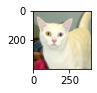

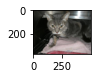

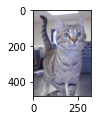

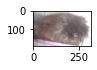

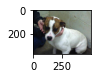

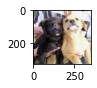

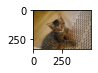

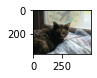

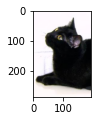

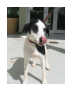

In [41]:
fig = plt.figure()
i=1

for idx in random_idx:
  ax = plt.figure().add_subplot(2,5,i)
  img = Image.open(train_list[idx])
  plt.imshow(img)
  i+=1

plt.axis('off')
plt.show()


In [42]:
train_list[0]

'/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/train/train/dog.9099.jpg'

In [43]:
train_list[0].split('/')[-1].split('.')[0]

'dog'

In [44]:
int(test_list[0].split('/')[-1].split('.')[0])

9099

In [45]:
print(len(train_list), len(test_list))

25000 12500


In [46]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size = 0.2)

Image Augmentation to prevent overfitting

In [47]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

load image sets (can be easily found in pytorch.org main page

In [48]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [49]:
train_data = dataset(train_list, transform = train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform = test_transforms)

In [50]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle= True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle= True)

In [51]:
print(len(train_data), len(train_loader))

20000 200


In [52]:
print(len(val_data), len(val_loader))

5000 50


In [53]:
train_data[0][0].shape

torch.Size([3, 224, 224])

# Building model
- 3 evo layers
- batchNormaliation for less overfitting

In [54]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [55]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [56]:
# loss func and optimizer

optimizer = optim.Adam(params = model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Training Network

In [57]:
epochs = 10

for epoch in range(epochs):
  epoch_loss = 0
  epoch_accuracy = 0

  for data, label in train_loader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    loss = criterion(output, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = ((output.argmax(dim=1) == label).float().mean())
    epoch_accuracy += acc/len(train_loader)
    epoch_loss += loss/len(train_loader)
  print(f'Epoch: {epoch+1}, train accuracy : {epoch_accuracy}, train loss: {epoch_loss}')

  with torch.no_grad():
    epoch_val_accuracy = 0
    epoch_val_loss = 0
    for data, label in val_loader:
      data = data.to(device)
      label = label.to(device)

      val_output = model(data)
      val_loss = criterion(val_output, label)

      acc = ((val_output.argmax(dim=1) == label).float().mean())
      epoch_val_accuracy += acc/ len(val_loader)
      epoch_val_loss += val_loss/ len(val_loader)

    print(f'Epoch : {epoch+1}, val_accuracy : {epoch_val_accuracy}, val_loss : {epoch_val_loss}')


Epoch: 1, train accuracy : 0.6344500780105591, train loss: 0.6307847499847412
Epoch : 1, val_accuracy : 0.684599757194519, val_loss : 0.592547595500946
Epoch: 2, train accuracy : 0.696300208568573, train loss: 0.5720399022102356
Epoch : 2, val_accuracy : 0.7203998565673828, val_loss : 0.5416653156280518
Epoch: 3, train accuracy : 0.7219999432563782, train loss: 0.5414693355560303
Epoch : 3, val_accuracy : 0.7456000447273254, val_loss : 0.5165673494338989
Epoch: 4, train accuracy : 0.7385000586509705, train loss: 0.5197364091873169
Epoch : 4, val_accuracy : 0.7467998266220093, val_loss : 0.5089589953422546
Epoch: 5, train accuracy : 0.7435502409934998, train loss: 0.5116477608680725
Epoch : 5, val_accuracy : 0.7501999139785767, val_loss : 0.5007466077804565
Epoch: 6, train accuracy : 0.7507001161575317, train loss: 0.49911701679229736
Epoch : 6, val_accuracy : 0.737599790096283, val_loss : 0.5135071277618408
Epoch: 7, train accuracy : 0.7592999339103699, train loss: 0.4825708270072937
E

In [58]:
dog_probs = []
model.eval()
with torch.no_grad():
  for data, fileid in test_loader:
    data = data.to(device)
    preds = model(data)
    preds_list = F.softmax(preds, dim = 1)[:, 1].tolist()
    dog_probs += list(zip(list(fileid), preds_list))


In [59]:
dog_probs.sort(key = lambda x: int(x[0]))
dog_probs

[('1', 0.7262914180755615),
 ('2', 0.9724851250648499),
 ('3', 0.6997968554496765),
 ('4', 0.9944021105766296),
 ('5', 0.17712531983852386),
 ('6', 0.260634183883667),
 ('7', 0.04731534421443939),
 ('8', 0.20328126847743988),
 ('9', 0.33619678020477295),
 ('10', 0.18649153411388397),
 ('11', 0.041653987020254135),
 ('12', 0.930930495262146),
 ('13', 0.37355050444602966),
 ('14', 0.2797839343547821),
 ('15', 0.36100754141807556),
 ('16', 0.4499611556529999),
 ('17', 0.5836628675460815),
 ('18', 0.9783395528793335),
 ('19', 0.4404838979244232),
 ('20', 0.3877091407775879),
 ('21', 0.3791862726211548),
 ('22', 0.12956508994102478),
 ('23', 0.6826149225234985),
 ('24', 0.7635917067527771),
 ('25', 0.619123637676239),
 ('26', 0.9029552936553955),
 ('27', 0.8104695677757263),
 ('28', 0.06396465748548508),
 ('29', 0.4258444607257843),
 ('30', 0.6707709431648254),
 ('31', 0.7671942710876465),
 ('32', 0.18000340461730957),
 ('33', 0.8472191095352173),
 ('34', 0.2879730761051178),
 ('35', 0.3427

In [60]:
idx = list(map(lambda x: x[0], dog_probs))
prob = list(map(lambda x: x[1], dog_probs))

In [61]:
submission = pd.DataFrame({'id':idx, 'label':prob})

In [62]:
submission

,id,label
0,1,0.726291
1,2,0.972485
2,3,0.699797
3,4,0.994402
4,5,0.177125
...,...,...
12495,12496,0.080281
12496,12497,0.179553
12497,12498,0.337859
12498,12499,0.970099


In [70]:
submission.to_csv(r'drive/MyDrive/Colab Notebooks/cat-dog-result.csv', index = False)

In [67]:
!pwd
!ls

/content
drive  result.csv  sample_data


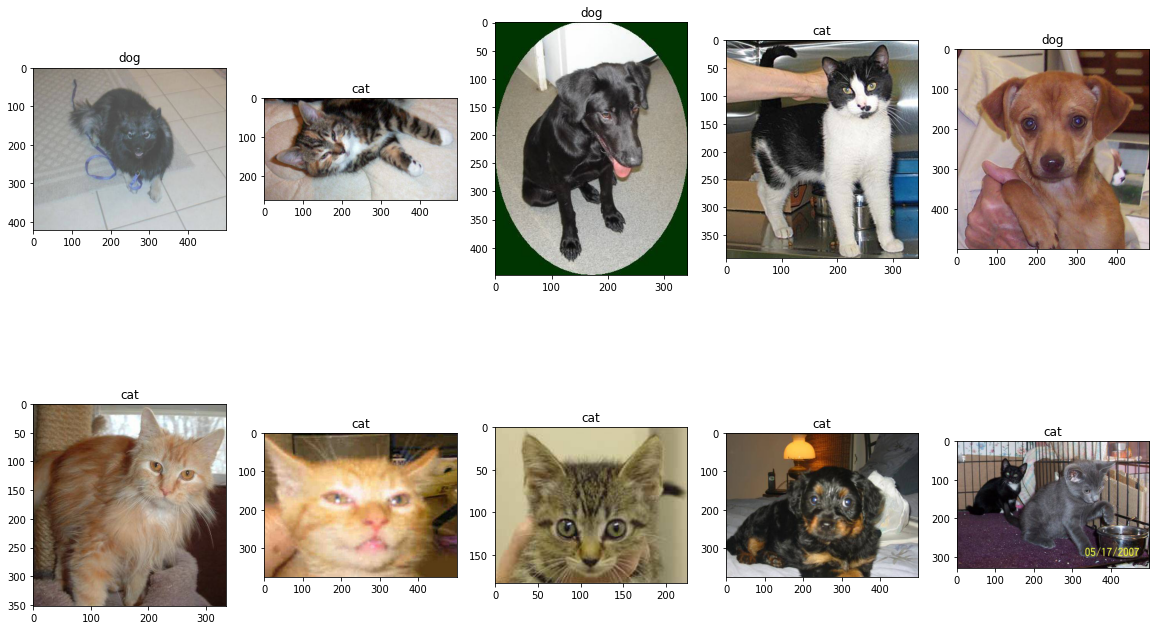

In [79]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize= (20, 12), facecolor = 'w')

for ax in axes.ravel():
  i = random.choice(submission['id'].values)

  label = submission.loc[submission['id'] == i, 'label'].values[0]
  if label > 0.5:
    label = 1
  else:
    label = 0
  
  img_path = f'/content/drive/MyDrive/Colab Notebooks/ML_Datasets/dogs-vs-cats/input/test/test/{i}.jpg'
  img = Image.open(img_path)

  ax.set_title(class_[label])
  ax.imshow(img)

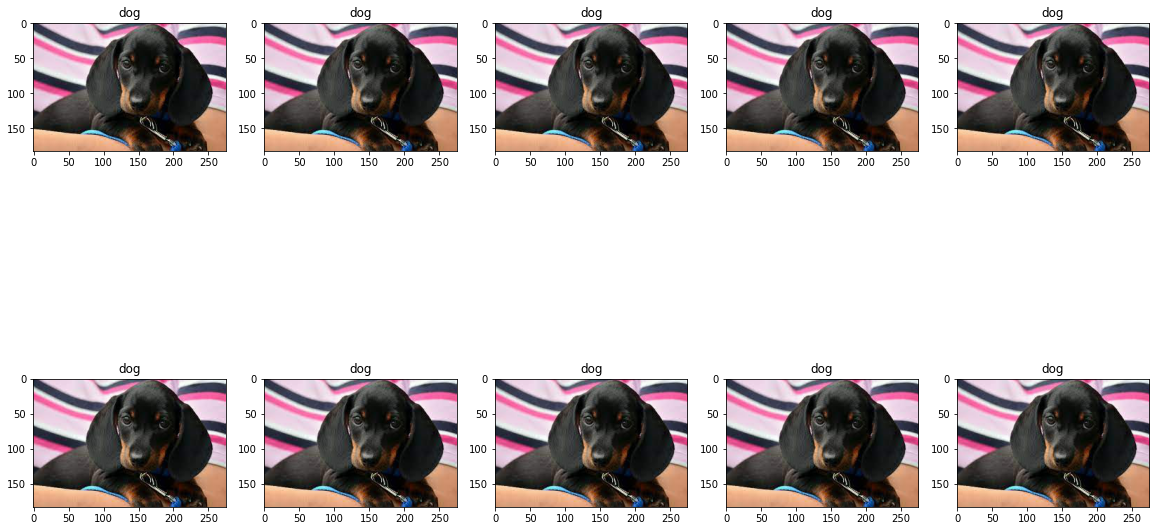

In [85]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize= (20, 12), facecolor = 'w')

for ax in axes.ravel():

  label = submission.loc[submission['id'] == i, 'label'].values[0]
  if label > 0.5:
    label = 1
  else:
    label = 0
  
  img_path = '/content/drive/MyDrive/Colab Notebooks/download.jpg'
  img = Image.open(img_path)

  ax.set_title(class_[label])
  ax.imshow(img)



